In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/results.csv', encoding='latin1')

df.head()

# Season - Match Season
# DateTime - Match Date and Time (yyyy-mm-dd hh:mm:ss)
# HomeTeam - Home Team
# AwayTeam - Away Team
# FTHG - Full Time Home Team Goals
# FTAG - Full Time Away Team Goals
# FTR - Full Time Result (H=Home Win, D=Draw, A=Away Win)
# HTHG - Half Time Home Team Goals
# HTAG - Half Time Away Team Goals
# HTR - Half Time Result (H=Home Win, D=Draw, A=Away Win)
# Referee - Match Referee
# HS - Home Team Shots
# AS - Away Team Shots
# HST - Home Team Shots on Target
# AST - Away Team Shots on Target
# HC - Home Team Corners
# AC - Away Team Corners
# HF - Home Team Fouls Committed
# AF - Away Team Fouls Committed
# HY - Home Team Yellow Cards
# AY - Away Team Yellow Cards
# HR - Home Team Red Cards
# AR - Away Team Red Cards

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

df['Season'] = df['Season'].str[:4].astype('int64')

df['DateTime'] = df['DateTime'].str[:10].astype('string')
df['DateTime'] = pd.to_datetime(df['DateTime'])

df['HTHG'] = df['HTHG'].astype('int64')
df['HTAG'] = df['HTAG'].astype('int64')
df['HS'] = df['HS'].astype('int64')
df['AS'] = df['AS'].astype('int64')
df['HST'] = df['HST'].astype('int64')
df['AST'] = df['AST'].astype('int64')
df['HC'] = df['HC'].astype('int64')
df['AC'] = df['AC'].astype('int64')
df['HF'] = df['HF'].astype('int64')
df['AF'] = df['AF'].astype('int64')
df['HY'] = df['HY'].astype('int64')
df['AY'] = df['AY'].astype('int64')
df['HR'] = df['HR'].astype('int64')
df['AR'] = df['AR'].astype('int64')

df.sort_values('DateTime', inplace=True)
df.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2000,2000-08-19,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,6,6,13,12,1,2,0,0
1,2000,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,7,7,19,14,1,2,0,0
2,2000,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,8,4,15,21,5,3,1,0
3,2000,2000-08-19,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,5,8,11,13,1,1,0,0
4,2000,2000-08-19,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,6,4,21,20,1,3,0,0


In [3]:
df.dtypes

Season               int64
DateTime    datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG                 int64
FTAG                 int64
FTR                 object
HTHG                 int64
HTAG                 int64
HTR                 object
Referee             object
HS                   int64
AS                   int64
HST                  int64
AST                  int64
HC                   int64
AC                   int64
HF                   int64
AF                   int64
HY                   int64
AY                   int64
HR                   int64
AR                   int64
dtype: object

In [4]:
unique_teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
unique_teams

array(['Charlton', 'Chelsea', 'Coventry', 'Derby', 'Leeds', 'Leicester',
       'Liverpool', 'Sunderland', 'Tottenham', 'Man United', 'Arsenal',
       'Bradford', 'Ipswich', 'Middlesbrough', 'West Ham', 'Southampton',
       'Everton', 'Man City', 'Newcastle', 'Aston Villa', 'Bolton',
       'Blackburn', 'Fulham', 'West Brom', 'Birmingham', 'Portsmouth',
       'Wolves', 'Norwich', 'Crystal Palace', 'Wigan', 'Reading',
       'Sheffield United', 'Watford', 'Hull', 'Stoke', 'Burnley',
       'Blackpool', 'QPR', 'Swansea', 'Cardiff', 'Bournemouth',
       'Brighton', 'Huddersfield', 'Brentford'], dtype=object)

In [5]:
team_matches_dict = {}

for team in unique_teams:
    team_matches = df[df['HomeTeam'].eq(team) | df['AwayTeam'].eq(team)].copy()
    team_matches['Team'] = team
    for index, row in team_matches.iterrows():
        if row['HomeTeam'] == team:
            team_matches.at[index, 'Opponent'] = row['AwayTeam']
            team_matches.at[index, 'Where'] = 'H'
            if row['FTR'] == 'H':
                team_matches.at[index, 'Points'] = 3
            elif row['FTR'] == 'D':
                team_matches.at[index, 'Points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'Points'] = 0
            team_matches.at[index, 'GS'] = row['FTHG']
            team_matches.at[index, 'GC'] = row['FTAG']
            team_matches.at[index, 'S'] = row['HS']
            team_matches.at[index, 'OS'] = row['AS']
            team_matches.at[index, 'ST'] = row['HST']
            team_matches.at[index, 'OST'] = row['AST']
            team_matches.at[index, 'C'] = row['HC']
            team_matches.at[index, 'OC'] = row['AC']
        else:
            team_matches.at[index, 'Opponent'] = row['HomeTeam']
            team_matches.at[index, 'Where'] = 'A'
            if row['FTR'] == 'H':
                team_matches.at[index, 'Points'] = 0
            elif row['FTR'] == 'D':
                team_matches.at[index, 'Points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'Points'] = 3
            team_matches.at[index, 'GS'] = row['FTAG']
            team_matches.at[index, 'GC'] = row['FTHG']
            team_matches.at[index, 'S'] = row['AS']
            team_matches.at[index, 'OS'] = row['HS']
            team_matches.at[index, 'ST'] = row['AST']
            team_matches.at[index, 'OST'] = row['HST']
            team_matches.at[index, 'C'] = row['AC']
            team_matches.at[index, 'OC'] = row['HC']
    int_columns = ['Points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
    team_matches[int_columns] = team_matches[int_columns].astype(int)
    team_matches = team_matches.drop(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],axis=1)
    team_matches_dict[team] = team_matches

In [6]:
team_matches_dict.get('Man United').head()

,Season,DateTime,Team,Opponent,Where,Points,GS,GC,S,OS,ST,OST,C,OC
9,2000,2000-08-20,Man United,Newcastle,H,3,2,0,19,9,9,6,7,1
12,2000,2000-08-22,Man United,Ipswich,A,1,1,1,15,13,6,8,6,4
27,2000,2000-08-26,Man United,West Ham,A,1,2,2,8,17,5,8,5,7
30,2000,2000-09-05,Man United,Bradford,H,3,6,0,21,6,12,4,5,1
44,2000,2000-09-09,Man United,Sunderland,H,3,3,0,15,5,7,1,4,4


In [7]:
def rolling_averages(team, cols, new_cols, number_of_games):
    team_df = team_matches_dict.get(team).sort_values('DateTime')
    rolling_stats = team_df[cols].rolling(number_of_games, closed='left').mean()
    team_df[new_cols] = rolling_stats.values
#     team_df.dropna(subset=new_cols, inplace=True)
    team_matches_dict[team] = team_df

    
cols = ['Points','GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
new_cols = [f'{c}_rolling' for c in cols]

for team in unique_teams:
    rolling_averages(team, cols, new_cols, 5)

In [8]:
team_matches_dict.get('Man United').tail()

,Season,DateTime,Team,Opponent,Where,Points,GS,GC,S,OS,ST,OST,C,OC,Points_rolling,GS_rolling,GC_rolling,S_rolling,OS_rolling,ST_rolling,OST_rolling,C_rolling,OC_rolling
8232,2021,2022-02-26,Man United,Watford,H,1,0,0,22,10,3,2,4,3,2.2,1.8,0.8,17.2,10.8,6.4,3.4,5.4,2.8
8245,2021,2022-03-06,Man United,Man City,A,0,1,4,5,24,2,10,3,9,1.8,1.6,0.8,18.0,11.6,6.4,3.6,5.6,2.8
8253,2021,2022-03-12,Man United,Tottenham,H,3,3,2,10,10,6,3,4,5,1.6,1.6,1.4,14.6,14.6,5.8,5.0,4.2,4.2
8274,2021,2022-04-02,Man United,Leicester,H,1,1,1,11,11,5,3,6,5,2.0,2.0,1.6,14.2,14.0,5.4,4.8,4.8,4.4
8280,2021,2022-04-09,Man United,Everton,A,0,0,1,12,7,4,3,7,5,1.6,1.8,1.8,12.6,14.2,5.0,4.8,4.0,5.0


In [9]:
cols = ['Points_rolling', 'GS_rolling', 'GC_rolling', 'S_rolling', 'OS_rolling', 'ST_rolling', 'OST_rolling', 'C_rolling', 'OC_rolling']
new_cols_home = [f'homeTeam_{c}' for c in cols]
new_cols_away = [f'awayTeam_{c}' for c in cols]

for index, row in df.iterrows():
    for i in range(len(cols)):
        df.at[index, new_cols_home[i]] = team_matches_dict.get(row['HomeTeam'])[cols[i]].loc[index]
        df.at[index, new_cols_away[i]] = team_matches_dict.get(row['AwayTeam'])[cols[i]].loc[index]
    
df.dropna(axis=0, how='any', inplace=True)

df.head()


,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,homeTeam_Points_rolling,awayTeam_Points_rolling,homeTeam_GS_rolling,awayTeam_GS_rolling,homeTeam_GC_rolling,awayTeam_GC_rolling,homeTeam_S_rolling,awayTeam_S_rolling,homeTeam_OS_rolling,awayTeam_OS_rolling,homeTeam_ST_rolling,awayTeam_ST_rolling,homeTeam_OST_rolling,awayTeam_OST_rolling,homeTeam_C_rolling,awayTeam_C_rolling,homeTeam_OC_rolling,awayTeam_OC_rolling
55,2000,2000-09-16,Sunderland,Derby,2,1,H,1,0,H,Paul Taylor,15,10,8,5,4,5,16,28,2,3,0,0,0.8,0.8,0.8,2.2,1.8,2.4,9.6,8.8,14.8,9.8,3.4,4.8,7.6,5.8,3.8,5.6,7.6,8.8
54,2000,2000-09-16,Southampton,Newcastle,2,0,H,0,0,D,Barry Knight,13,10,9,7,4,8,14,14,0,0,0,0,0.6,2.0,1.4,1.4,1.8,0.8,11.8,11.2,9.4,12.4,5.0,5.2,5.0,4.4,8.2,5.4,6.2,5.4
51,2000,2000-09-16,Charlton,Tottenham,1,0,H,1,0,H,Jeff Winter,9,10,5,5,7,5,8,10,0,0,0,0,1.0,2.0,2.0,1.6,2.2,1.2,10.0,13.4,12.4,12.8,6.8,5.2,6.0,5.6,7.0,5.6,7.0,4.2
49,2000,2000-09-16,Arsenal,Coventry,2,1,H,1,0,H,Mike Dean,18,6,13,2,8,4,5,13,1,2,0,0,1.6,1.4,2.0,1.0,1.4,1.4,16.0,8.8,8.6,13.2,8.8,4.0,4.0,5.8,8.6,6.0,5.4,5.8
52,2000,2000-09-16,Everton,Man United,1,3,A,0,3,A,Dermot Gallagher,6,17,4,9,6,5,10,11,4,1,0,0,1.4,2.2,1.8,2.8,1.6,0.6,12.0,15.6,10.4,10.0,7.6,7.8,5.6,5.4,6.0,5.4,5.4,3.4


In [10]:
df['homeTeam_code'] = df['HomeTeam'].astype('category').cat.codes
df['awayTeam_code'] = df['AwayTeam'].astype('category').cat.codes

cols = ['Points','GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
for col in cols:
    df[f'{col}_difference'] = df[f'homeTeam_{col}_rolling'] - df[f'awayTeam_{col}_rolling']
    
df['target'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})

df.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,homeTeam_Points_rolling,awayTeam_Points_rolling,homeTeam_GS_rolling,awayTeam_GS_rolling,homeTeam_GC_rolling,awayTeam_GC_rolling,homeTeam_S_rolling,awayTeam_S_rolling,homeTeam_OS_rolling,awayTeam_OS_rolling,homeTeam_ST_rolling,awayTeam_ST_rolling,homeTeam_OST_rolling,awayTeam_OST_rolling,homeTeam_C_rolling,awayTeam_C_rolling,homeTeam_OC_rolling,awayTeam_OC_rolling,homeTeam_code,awayTeam_code,Points_difference,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,target
55,2000,2000-09-16,Sunderland,Derby,2,1,H,1,0,H,Paul Taylor,15,10,8,5,4,5,16,28,2,3,0,0,0.8,0.8,0.8,2.2,1.8,2.4,9.6,8.8,14.8,9.8,3.4,4.8,7.6,5.8,3.8,5.6,7.6,8.8,36,16,0.0,-1.4,-0.6,0.8,5.0,-1.4,1.8,-1.8,-1.2,1
54,2000,2000-09-16,Southampton,Newcastle,2,0,H,0,0,D,Barry Knight,13,10,9,7,4,8,14,14,0,0,0,0,0.6,2.0,1.4,1.4,1.8,0.8,11.8,11.2,9.4,12.4,5.0,5.2,5.0,4.4,8.2,5.4,6.2,5.4,34,28,-1.4,0.0,1.0,0.6,-3.0,-0.2,0.6,2.8,0.8,1
51,2000,2000-09-16,Charlton,Tottenham,1,0,H,1,0,H,Jeff Winter,9,10,5,5,7,5,8,10,0,0,0,0,1.0,2.0,2.0,1.6,2.2,1.2,10.0,13.4,12.4,12.8,6.8,5.2,6.0,5.6,7.0,5.6,7.0,4.2,12,38,-1.0,0.4,1.0,-3.4,-0.4,1.6,0.4,1.4,2.8,1
49,2000,2000-09-16,Arsenal,Coventry,2,1,H,1,0,H,Mike Dean,18,6,13,2,8,4,5,13,1,2,0,0,1.6,1.4,2.0,1.0,1.4,1.4,16.0,8.8,8.6,13.2,8.8,4.0,4.0,5.8,8.6,6.0,5.4,5.8,0,14,0.2,1.0,0.0,7.2,-4.6,4.8,-1.8,2.6,-0.4,1
52,2000,2000-09-16,Everton,Man United,1,3,A,0,3,A,Dermot Gallagher,6,17,4,9,6,5,10,11,4,1,0,0,1.4,2.2,1.8,2.8,1.6,0.6,12.0,15.6,10.4,10.0,7.6,7.8,5.6,5.4,6.0,5.4,5.4,3.4,17,26,-0.8,-1.0,1.0,-3.6,0.4,-0.2,0.2,0.6,2.0,-1


In [11]:
df.Season.value_counts().sort_index()

Season
2000    329
2001    365
2002    370
2003    371
2004    371
2005    375
2006    366
2007    380
2008    370
2009    375
2010    375
2011    370
2012    380
2013    375
2014    380
2015    375
2016    380
2017    370
2018    380
2019    380
2020    380
2021    304
Name: count, dtype: int64

In [12]:
train = df[(df['Season'] >= 2000) & (df['Season'] <= 2019)]

train

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,homeTeam_Points_rolling,awayTeam_Points_rolling,homeTeam_GS_rolling,awayTeam_GS_rolling,homeTeam_GC_rolling,awayTeam_GC_rolling,homeTeam_S_rolling,awayTeam_S_rolling,homeTeam_OS_rolling,awayTeam_OS_rolling,homeTeam_ST_rolling,awayTeam_ST_rolling,homeTeam_OST_rolling,awayTeam_OST_rolling,homeTeam_C_rolling,awayTeam_C_rolling,homeTeam_OC_rolling,awayTeam_OC_rolling,homeTeam_code,awayTeam_code,Points_difference,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,target
55,2000,2000-09-16,Sunderland,Derby,2,1,H,1,0,H,Paul Taylor,15,10,8,5,4,5,16,28,2,3,0,0,0.8,0.8,0.8,2.2,1.8,2.4,9.6,8.8,14.8,9.8,3.4,4.8,7.6,5.8,3.8,5.6,7.6,8.8,36,16,0.0,-1.4,-0.6,0.8,5.0,-1.4,1.8,-1.8,-1.2,1
54,2000,2000-09-16,Southampton,Newcastle,2,0,H,0,0,D,Barry Knight,13,10,9,7,4,8,14,14,0,0,0,0,0.6,2.0,1.4,1.4,1.8,0.8,11.8,11.2,9.4,12.4,5.0,5.2,5.0,4.4,8.2,5.4,6.2,5.4,34,28,-1.4,0.0,1.0,0.6,-3.0,-0.2,0.6,2.8,0.8,1
51,2000,2000-09-16,Charlton,Tottenham,1,0,H,1,0,H,Jeff Winter,9,10,5,5,7,5,8,10,0,0,0,0,1.0,2.0,2.0,1.6,2.2,1.2,10.0,13.4,12.4,12.8,6.8,5.2,6.0,5.6,7.0,5.6,7.0,4.2,12,38,-1.0,0.4,1.0,-3.4,-0.4,1.6,0.4,1.4,2.8,1
49,2000,2000-09-16,Arsenal,Coventry,2,1,H,1,0,H,Mike Dean,18,6,13,2,8,4,5,13,1,2,0,0,1.6,1.4,2.0,1.0,1.4,1.4,16.0,8.8,8.6,13.2,8.8,4.0,4.0,5.8,8.6,6.0,5.4,5.8,0,14,0.2,1.0,0.0,7.2,-4.6,4.8,-1.8,2.6,-0.4,1
52,2000,2000-09-16,Everton,Man United,1,3,A,0,3,A,Dermot Gallagher,6,17,4,9,6,5,10,11,4,1,0,0,1.4,2.2,1.8,2.8,1.6,0.6,12.0,15.6,10.4,10.0,7.6,7.8,5.6,5.4,6.0,5.4,5.4,3.4,17,26,-0.8,-1.0,1.0,-3.6,0.4,-0.2,0.2,0.6,2.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7594,2019,2020-07-26,Everton,Bournemouth,1,3,A,1,2,A,C Kavanagh,13,13,5,7,2,5,11,9,1,0,0,0,1.0,0.8,0.6,1.4,1.2,2.0,8.4,10.4,13.2,13.0,2.4,3.0,2.8,5.4,3.4,6.0,5.4,7.0,17,6,0.2,-0.8,-0.8,-2.0,0.2,-0.6,-2.6,-2.6,-1.6,-1
7593,2019,2020-07-26,Crystal Palace,Tottenham,1,1,D,0,1,A,A Marriner,13,7,2,2,7,2,11,13,3,2,0,0,0.0,2.6,0.4,1.8,2.4,0.4,9.8,10.2,13.8,15.8,3.6,3.8,5.8,4.2,3.8,6.2,5.8,7.4,15,38,-2.6,-1.4,2.0,-0.4,-2.0,-0.2,1.6,-2.4,-1.6,0
7592,2019,2020-07-26,Chelsea,Wolves,2,0,H,2,0,H,S Attwell,11,5,3,1,3,3,10,16,2,3,0,0,1.8,1.4,2.0,1.2,2.0,0.8,16.4,11.0,8.2,7.4,6.0,3.8,3.6,2.8,5.6,4.4,4.2,3.6,13,43,0.4,0.8,1.2,5.4,0.8,2.2,0.8,1.2,0.6,1
7591,2019,2020-07-26,Burnley,Brighton,1,2,A,1,1,D,J Moss,13,14,2,4,6,7,11,11,3,0,0,0,1.8,1.0,1.2,0.6,0.6,1.8,11.0,8.8,14.8,18.0,3.8,1.8,4.8,4.8,4.6,4.2,9.0,6.4,10,9,0.8,0.6,-1.2,2.2,-3.2,2.0,0.0,0.4,2.6,-1


In [13]:
test = df[df['Season'] == 2020]

test

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,homeTeam_Points_rolling,awayTeam_Points_rolling,homeTeam_GS_rolling,awayTeam_GS_rolling,homeTeam_GC_rolling,awayTeam_GC_rolling,homeTeam_S_rolling,awayTeam_S_rolling,homeTeam_OS_rolling,awayTeam_OS_rolling,homeTeam_ST_rolling,awayTeam_ST_rolling,homeTeam_OST_rolling,awayTeam_OST_rolling,homeTeam_C_rolling,awayTeam_C_rolling,homeTeam_OC_rolling,awayTeam_OC_rolling,homeTeam_code,awayTeam_code,Points_difference,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,target
7600,2020,2020-09-12,Fulham,Arsenal,0,3,A,0,1,A,C Kavanagh,5,13,2,6,2,3,12,12,2,2,0,0,1.8,1.4,0.8,1.4,1.0,1.4,11.8,9.4,13.6,15.8,3.2,3.6,5.2,6.2,6.0,6.0,4.2,7.2,18,0,0.4,-0.6,-0.4,2.4,-2.2,-0.4,-1.0,0.0,-3.0,-1
7601,2020,2020-09-12,Crystal Palace,Southampton,1,0,H,1,0,H,J Moss,5,9,3,5,7,3,14,11,2,1,0,0,0.2,1.8,0.6,1.8,2.0,1.0,11.0,15.2,12.2,9.0,3.8,5.4,5.4,3.2,3.8,6.8,5.6,4.4,15,34,-1.6,-1.2,1.0,-4.2,3.2,-1.6,2.2,-3.0,1.2,1
7602,2020,2020-09-12,Liverpool,Leeds,4,3,H,3,2,H,M Oliver,22,6,6,3,9,0,9,6,1,0,0,0,2.0,0.2,2.6,1.0,1.6,3.0,18.0,8.8,6.8,14.8,7.6,3.8,2.6,8.4,9.0,5.0,3.2,5.0,24,22,1.8,1.6,-1.4,9.2,-8.0,3.8,-5.8,4.0,-1.8,1
7603,2020,2020-09-12,West Ham,Newcastle,0,2,A,0,0,D,S Attwell,15,15,3,2,8,7,13,7,2,2,0,0,1.6,0.2,1.8,0.6,0.8,2.6,14.4,10.2,11.4,14.6,4.0,2.8,3.4,5.6,5.6,3.8,3.2,5.4,41,28,1.4,1.2,-1.8,4.2,-3.2,1.2,-2.2,1.8,-2.2,-1
7604,2020,2020-09-13,West Brom,Leicester,0,3,A,0,0,D,A Taylor,7,13,1,7,2,5,12,9,1,1,0,0,2.0,0.8,1.0,0.8,0.8,2.0,9.6,15.8,13.8,8.0,2.8,5.2,3.8,3.6,3.8,6.4,5.2,4.8,40,23,1.2,0.2,-1.2,-6.2,5.8,-2.4,0.2,-2.6,0.4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973,2020,2021-05-23,Leeds,West Brom,3,1,H,2,0,H,D Coote,17,14,9,5,8,3,12,12,2,1,0,0,2.0,0.4,1.8,1.2,0.6,2.2,12.8,11.2,15.6,21.2,5.0,3.2,3.8,8.6,6.4,6.0,4.8,8.8,22,40,1.6,0.6,-1.6,1.6,-5.6,1.8,-4.8,0.4,-4.0,1
7972,2020,2021-05-23,Fulham,Newcastle,0,2,A,0,1,A,C Kavanagh,14,10,0,4,5,4,12,6,1,0,0,0,0.4,1.4,0.6,1.8,1.8,1.8,10.4,10.6,13.0,18.4,3.0,4.2,5.6,6.0,4.6,4.2,5.6,5.8,18,28,-1.0,-1.2,0.0,-0.2,-5.4,-1.2,-0.4,0.4,-0.2,-1
7971,2020,2021-05-23,Aston Villa,Chelsea,2,1,H,1,0,H,S Attwell,6,23,3,7,2,9,11,12,3,3,0,1,1.4,2.4,1.4,1.4,1.6,0.6,15.2,14.8,16.4,9.4,4.2,5.4,5.4,2.8,6.4,4.0,4.2,4.8,1,13,-1.0,0.0,1.0,0.4,7.0,-1.2,2.6,2.4,-0.6,1
7970,2020,2021-05-23,Arsenal,Brighton,2,0,H,0,0,D,J Moss,16,5,5,1,11,3,10,8,0,0,0,0,2.4,1.4,1.8,1.4,0.6,1.2,11.8,13.6,11.2,11.4,4.0,4.0,2.8,3.6,5.6,5.4,5.4,5.4,0,9,1.0,0.4,-0.6,-1.8,-0.2,0.0,-0.8,0.2,0.0,1


In [14]:
# predictors = [
#     'homeTeam_GS_rolling',
#     'awayTeam_GS_rolling',
#     'homeTeam_GC_rolling',
#     'awayTeam_GC_rolling',
#     'homeTeam_S_rolling', 
#     'awayTeam_S_rolling', 
#     'homeTeam_OS_rolling',
#     'awayTeam_OS_rolling', 
#     'homeTeam_ST_rolling', 
#     'awayTeam_ST_rolling', 
#     'homeTeam_OST_rolling', 
#     'awayTeam_OST_rolling', 
#     'homeTeam_C_rolling', 
#     'awayTeam_C_rolling', 
#     'homeTeam_OC_rolling', 
#     'awayTeam_OC_rolling',
#     'homeTeam_code', 
#     'awayTeam_code'
#     'Points_difference',
#     'GS_difference',
#     'GC_difference',
#     'S_difference',
#     'OS_difference',
#     'ST_difference',
#     'OST_difference',
#     'C_difference',
#     'OC_difference'
# ]

predictors = [
    'homeTeam_code', 
    'awayTeam_code',
    'Points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Best accuracy: 0.51; n=27


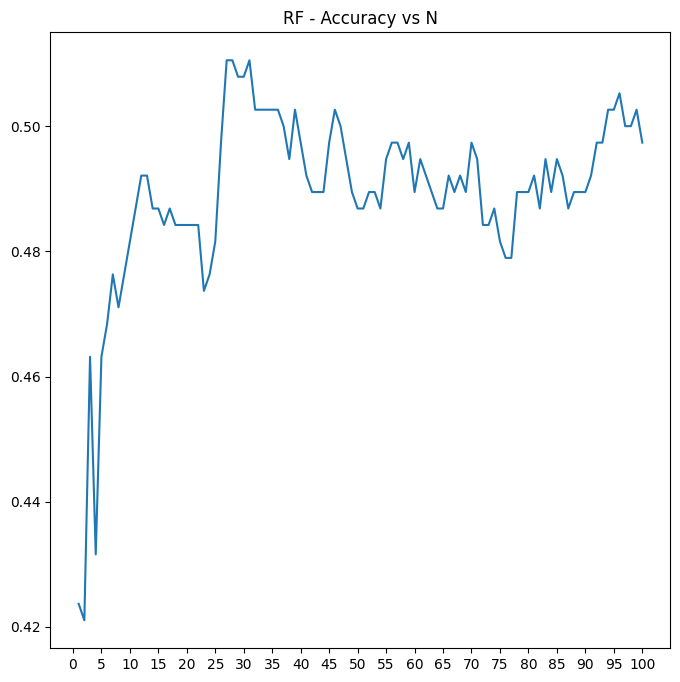

In [36]:
import matplotlib.pyplot as plt

plot_scores_rf = []

for n_estimators in range(1, 101):
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=10, random_state=1)
    clf_rf.fit(X_train,y_train)
    test_preds = clf_rf.predict(X_test)
    scores = accuracy_score(y_test, test_preds)
    plot_scores_rf.append(scores)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_rf)
plt.title("RF - Accuracy vs N")
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_rf)
best_n_rf = plot_scores_rf.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy:.2f}; n={best_n_rf}')

In [16]:
rf = RandomForestClassifier(n_estimators=27, min_samples_split=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=27, random_state=1)

In [17]:
rf.feature_importances_

array([0.18124196, 0.18159038, 0.14592553, 0.1375645 , 0.14381675,
       0.20986087])

In [18]:
rf_test_preds = rf.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, rf_test_preds)
print(f'Random Forest Test Accuracy: {rf_test_accuracy:.2f}')

Random Forest Test Accuracy: 0.47


In [21]:
class_probabilities = rf.predict_proba(X_test)
class_probabilities

array([[0.27320725, 0.42560742, 0.30118534],
       [0.4004459 , 0.37282576, 0.22672835],
       [0.03022286, 0.17535921, 0.79441793],
       ...,
       [0.28938993, 0.32088611, 0.38972396],
       [0.2474729 , 0.14595692, 0.60657018],
       [0.35934734, 0.22960897, 0.41104369]])

In [47]:
rf_train_preds = rf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
print(f'Random Forest Train Accuracy: {rf_train_accuracy:.2f}')

Random Forest Train Accuracy: 0.86


In [48]:
combined = pd.DataFrame(dict(actual=y_test, prediction = rf_test_preds))
pd.crosstab(index=combined['actual'], columns = combined['prediction'])

prediction,-1,0,1
actual,,,
-1,66,14,73
0,24,12,47
1,23,5,116


In [75]:
train_weights = train['Season'].apply(lambda x: 2 if x in [2019, 2018, 2017] else 1)
train_weights

3807    1
3805    1
3804    1
3800    1
3802    1
       ..
7594    2
7593    2
7592    2
7591    2
7590    2
Name: Season, Length: 3765, dtype: int64

In [76]:
rf2 = RandomForestClassifier(n_estimators=best_n_rf, min_samples_split=10, random_state=1)
rf2.fit(X_train, y_train, sample_weight=train_weights)

RandomForestClassifier(min_samples_split=10, n_estimators=27, random_state=1)

In [77]:
rf2_test_preds = rf2.predict(X_test)

rf2_test_accuracy = accuracy_score(y_test, rf2_test_preds)
print(f'Random Forest With Weights Test Accuracy: {rf2_test_accuracy:.2f}')

Random Forest With Weights Test Accuracy: 0.47


In [78]:
rf2_train_preds = rf2.predict(X_train)

rf2_train_accuracy = accuracy_score(y_train, rf2_train_preds)
print(f'Random Forest Train Accuracy: {rf2_train_accuracy:.2f}')

Random Forest Train Accuracy: 0.85


Best accuracy: 0.49; n=58


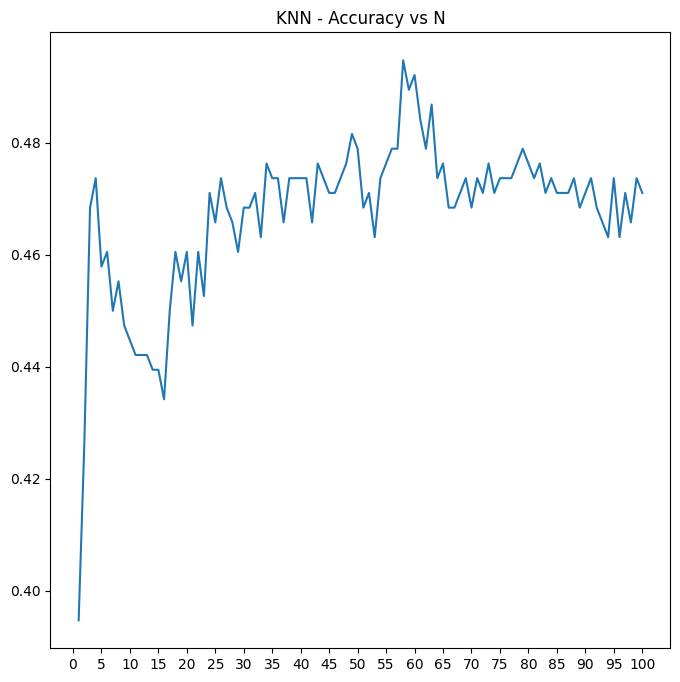

In [27]:
from sklearn.neighbors import KNeighborsClassifier

plot_scores_knn = []

for n_neighbors in range(1, 101):
    clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf_knn.fit(X_train,y_train)
    test_preds = clf_knn.predict(X_test)
    scores = accuracy_score(y_test, test_preds)
    plot_scores_knn.append(scores)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101),plot_scores_knn)
plt.title("KNN - Accuracy vs N")
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_knn)
best_n = plot_scores_knn.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy:.2f}; n={best_n}')

In [28]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=58)

In [29]:
knn_test_preds = knn.predict(X_test)

knn_test_accuracy = accuracy_score(y_test, knn_test_preds)
print(f'KNN Test accuracy: {knn_test_accuracy:.2f}')

KNN Test accuracy: 0.49


In [30]:
knn_train_preds = knn.predict(X_train)

knn_train_accuracy = accuracy_score(y_train, knn_train_preds)
print(f'KNN Train accuracy: {knn_train_accuracy:.2f}')

KNN Train accuracy: 0.52


In [31]:
combined = pd.DataFrame(dict(actual=y_test, prediction=knn_test_preds))
pd.crosstab(index=combined['actual'], columns = combined['prediction'])

prediction,-1,0,1
actual,,,
-1,62,3,88
0,23,2,58
1,20,0,124


In [130]:
from sklearn.svm import SVC

In [131]:
svm = SVC(kernel='linear', C=0.5, random_state=1)

In [132]:
svm.fit(X_train, y_train)

SVC(C=0.5, kernel='linear', random_state=1)

In [133]:
svm_test_preds = svm.predict(X_test)

svm_test_accuracy = accuracy_score(y_test, svm_test_preds)
print(f'SVM Test Accuracy: {svm_test_accuracy:.2f}')

SVM Test Accuracy: 0.45


In [134]:
svm_train_preds = svm.predict(X_train)

svm_train_accuracy = accuracy_score(y_train, svm_train_preds)
print(f'SVM Train accuracy: {svm_train_accuracy:.2f}')

SVM Train accuracy: 0.51


In [115]:
import xgboost as xgb

In [116]:
xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=1
)

In [120]:
y_train_adjusted = y_train + 1
y_test_adjusted = y_test + 1

In [124]:
xgb.fit(X_train, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
xgb_test_preds = xgb.predict(X_test)

xgb_test_accuracy = accuracy_score(y_test_adjusted, xgb_test_preds)
print(f'XGB Test Accuracy: {xgb_test_accuracy:.2f}')

XGB Test Accuracy: 0.47


In [127]:
xgb_train_preds = xgb.predict(X_train)

xgb_train_accuracy = accuracy_score(y_train_adjusted, xgb_train_preds)
print(f'XGB Train accuracy: {xgb_train_accuracy:.2f}')

XGB Train accuracy: 0.57


In [137]:
from sklearn.naive_bayes import MultinomialNB

In [149]:
predictors = [
    'homeTeam_GS_rolling',
    'awayTeam_GS_rolling',
    'homeTeam_GC_rolling',
    'awayTeam_GC_rolling',
#     'homeTeam_S_rolling', 
#     'awayTeam_S_rolling', 
#     'homeTeam_OS_rolling',
#     'awayTeam_OS_rolling', 
    'homeTeam_ST_rolling', 
    'awayTeam_ST_rolling', 
#     'homeTeam_OST_rolling', 
#     'awayTeam_OST_rolling', 
#     'homeTeam_C_rolling', 
#     'awayTeam_C_rolling', 
#     'homeTeam_OC_rolling', 
#     'awayTeam_OC_rolling',
    'homeTeam_code', 
    'awayTeam_code',
    'homeTeam_Points_rolling',
    'awayTeam_Points_rolling'
#     'Points_difference',
#     'GS_difference',
#     'GC_difference',
#     'S_difference',
#     'OS_difference',
#     'ST_difference',
#     'OST_difference',
#     'C_difference',
#     'OC_difference'
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [150]:
nb = MultinomialNB()

In [151]:
nb.fit(X_train, y_train)

MultinomialNB()

In [1]:
nb_test_preds = nb_model.predict(X_test)

nb_test_accuracy = accuracy_score(y_test, nb_test_preds)
print(f'Naive Bayes Test Accuracy: {nb_test_accuracy:.2f}')

NameError: name 'nb_model' is not defined

In [32]:
import numpy as np
import matplotlib.pyplot as plt

results = test[['HomeTeam', 'AwayTeam', 'FTR']].copy()
results['Result_RF'] = np.vectorize({1: 'H', 0: 'D', -1: 'A'}.get)(rf_test_preds)
results['Result_KNN'] = np.vectorize({1: 'H', 0: 'D', -1: 'A'}.get)(knn_test_preds)

results['Actual_Points'] = 0
results['RF_Predicted_Points'] = 0
results['KNN_Predicted_Points'] = 0

actual_points_dict = {}
rf_predicted_points_dict = {}
knn_predicted_points_dict = {}

for index, row in results.iterrows():
    
    # Actual points
    if row['HomeTeam'] not in actual_points_dict:
        actual_points_dict[row['HomeTeam']] = 0
    if row['AwayTeam'] not in actual_points_dict:
        actual_points_dict[row['AwayTeam']] = 0

    if row['FTR'] == 'H':
        actual_points_dict[row['HomeTeam']] += 3
    elif row['FTR'] == 'D':
        actual_points_dict[row['HomeTeam']] += 1
        actual_points_dict[row['AwayTeam']] += 1
    elif row['FTR'] == 'A':
        actual_points_dict[row['AwayTeam']] += 3

    # RF points
    if row['HomeTeam'] not in rf_predicted_points_dict:
        rf_predicted_points_dict[row['HomeTeam']] = 0
    if row['AwayTeam'] not in rf_predicted_points_dict:
        rf_predicted_points_dict[row['AwayTeam']] = 0

    if row['Result_RF'] == 'H':
        rf_predicted_points_dict[row['HomeTeam']] += 3
    elif row['Result_RF'] == 'D':
        rf_predicted_points_dict[row['HomeTeam']] += 1
        rf_predicted_points_dict[row['AwayTeam']] += 1
    elif row['Result_RF'] == 'A':
        rf_predicted_points_dict[row['AwayTeam']] += 3
        
    # KNN points
    if row['HomeTeam'] not in knn_predicted_points_dict:
        knn_predicted_points_dict[row['HomeTeam']] = 0
    if row['AwayTeam'] not in knn_predicted_points_dict:
        knn_predicted_points_dict[row['AwayTeam']] = 0

    if row['Result_KNN'] == 'H':
        knn_predicted_points_dict[row['HomeTeam']] += 3
    elif row['Result_KNN'] == 'D':
        knn_predicted_points_dict[row['HomeTeam']] += 1
        knn_predicted_points_dict[row['AwayTeam']] += 1
    elif row['Result_KNN'] == 'A':
        knn_predicted_points_dict[row['AwayTeam']] += 3

actual_table = pd.DataFrame(list(actual_points_dict.items()), 
                            columns=['Team', 'Actual_Points'])

rf_predicted_table = pd.DataFrame(list(rf_predicted_points_dict.items()), 
                                  columns=['Team', 'RF_Predicted_Points'])

knn_predicted_table = pd.DataFrame(list(knn_predicted_points_dict.items()), 
                                  columns=['Team', 'KNN_Predicted_Points'])

actual_table = actual_table.sort_values(by='Actual_Points', ascending=False).reset_index(drop=True)
rf_predicted_table = rf_predicted_table.sort_values(by='RF_Predicted_Points', 
                                                 ascending=False).reset_index(drop=True)
knn_predicted_table = knn_predicted_table.sort_values(by='KNN_Predicted_Points', 
                                                 ascending=False).reset_index(drop=True)

actual_table.index += 1
rf_predicted_table.index += 1
knn_predicted_table.index += 1

print("Actual Points Table:")
display(actual_table)

print("\nRF Predicted Points Table:")
display(rf_predicted_table)

print("\nKNN Predicted Points Table:")
display(knn_predicted_table)





Actual Points Table:


,Team,Actual_Points
1,Man City,86
2,Man United,74
3,Liverpool,69
4,Chelsea,67
5,Leicester,66
6,West Ham,65
7,Tottenham,62
8,Arsenal,61
9,Leeds,59
10,Everton,59



RF Predicted Points Table:


,Team,RF_Predicted_Points
1,Man United,100
2,Man City,99
3,Chelsea,84
4,Liverpool,77
5,Leicester,70
6,Leeds,70
7,Tottenham,62
8,Arsenal,55
9,Everton,50
10,Burnley,49



KNN Predicted Points Table:


,Team,KNN_Predicted_Points
1,Man City,108
2,Man United,102
3,Leicester,96
4,Liverpool,96
5,Leeds,78
6,Chelsea,78
7,Crystal Palace,60
8,Aston Villa,57
9,Arsenal,55
10,Tottenham,52
